## Feature Selection Methods: 

This notebook is experimenting feature selection for Reading subject Learning Loss with methods such as:
- Variance Threshold
- L1 Regularization (Lasso)
- Random Forest Feature Importance 
- Permutation Importance
    - with Random Forest
    - with Ridge Regression
- Recursive Feature Elimination (RFE)
    - with Random Forest
    - with Ridge Regression
- Sequential Feature Selection (SFS)
    - with KNN
    - with Ridge Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

**Loading Data**

Cleaned and integrated from [Data_Integration.ipynb](Data_Integration.ipynb)

In [3]:
df = pd.read_csv('DATA_Texas_District_v2.csv', sep=',', header=0)
print(df.shape)

(955, 90)


**Get dummies for categorical feature `Locale`**

In [4]:
df = pd.get_dummies(df, columns=['Locale'], prefix='Locale')
print(df.shape)

(955, 101)


**Split data**

In [5]:
labels = ['Label_Math', 'Label_Reading', 'Label_All']

cols_drop = ['% Tested Math G3 Diff',
            '% Tested Math G4 Diff',
            '% Tested Math G5 Diff',
            '% Tested Math G6 Diff',
            '% Tested Math G7 Diff',
            '% Tested Math G8 Diff',
            'District #', 'County #']

y = df['Label_Reading'].values
X = df.drop(columns=labels + cols_drop).values
columns = df.drop(columns=labels + cols_drop).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=123, shuffle=True)
print(X.shape)

(955, 90)


**Normalization**

In [6]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
random_state=123
results = pd.DataFrame()

### Variance Threshold ###

In [8]:
from sklearn.feature_selection import VarianceThreshold

# dropping columns where 1-threshold of the values are similar
# a feature contains only 0s 80% of the time or only 1s 80% of the time
sel = VarianceThreshold(threshold=.8*(1-.8))

sel.fit_transform(X)
selected_var = columns[sel.get_support()]

temp = pd.DataFrame({'feature': columns,
                     'method': 'Variance Threshold',
                     'model': 'N/A',
                     'score': [1 if ft in selected_var else 0 for ft in columns],
                     'score_type': 'N/A'})
results = pd.concat([results, temp], ignore_index=True)

print('n_features_selected:',selected_var.shape[0])
print('Features Selected: ', selected_var)

n_features_selected: 20
Features Selected:  Index(['Unemployed Level Diff', 'Median Age 10', 'Median Age Male 10',
       'Median Age Female 10', '# of Households 10', 'Avg Household Size 10',
       '# of Families 10', 'Avg Family Size 10', '# of Housing Units 10',
       'County Population', 'CARES ESSER I 20', 'CRRSA ESSER II 21',
       'ARP ESSER III 21', 'ESSER-SUPP 22', 'ESSER-SUPP 23',
       '% Reduced-price Lunch Diff', '% Asian Diff', '% Black Diff',
       '% Prek Diff', 'Locale_42-Rural: Distant'],
      dtype='object')


### L1(Lasso) Regularization ###

In [9]:
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, multi_class='ovr', random_state=random_state)
lasso.fit(X_train, y_train)

print('Train Accuracy: {:0.2f}'.format(lasso.score(X_train, y_train)))
print('Test Accuracy: {:0.2f}'.format(lasso.score(X_test, y_test)))

df_lasso = pd.DataFrame()

for c, cla in zip(lasso.coef_, ['Loss', 'Expected', 'Gain']):
    temp = pd.DataFrame({'feature': columns, 'coef': c, 'class': cla})
    df_lasso = pd.concat([df_lasso, temp], ignore_index=True)

df_lasso2 = df_lasso.groupby(['feature'], as_index=False).agg({'coef': 'sum'})

temp = pd.DataFrame({'feature': df_lasso2['feature'], 
                        'method': 'Regularization',
                        'model': 'Lasso', 
                        'score': df_lasso2['coef'],
                        'score_type': 'N/A'})

results = pd.concat([results, temp], ignore_index=True)

Train Accuracy: 0.60
Test Accuracy: 0.58


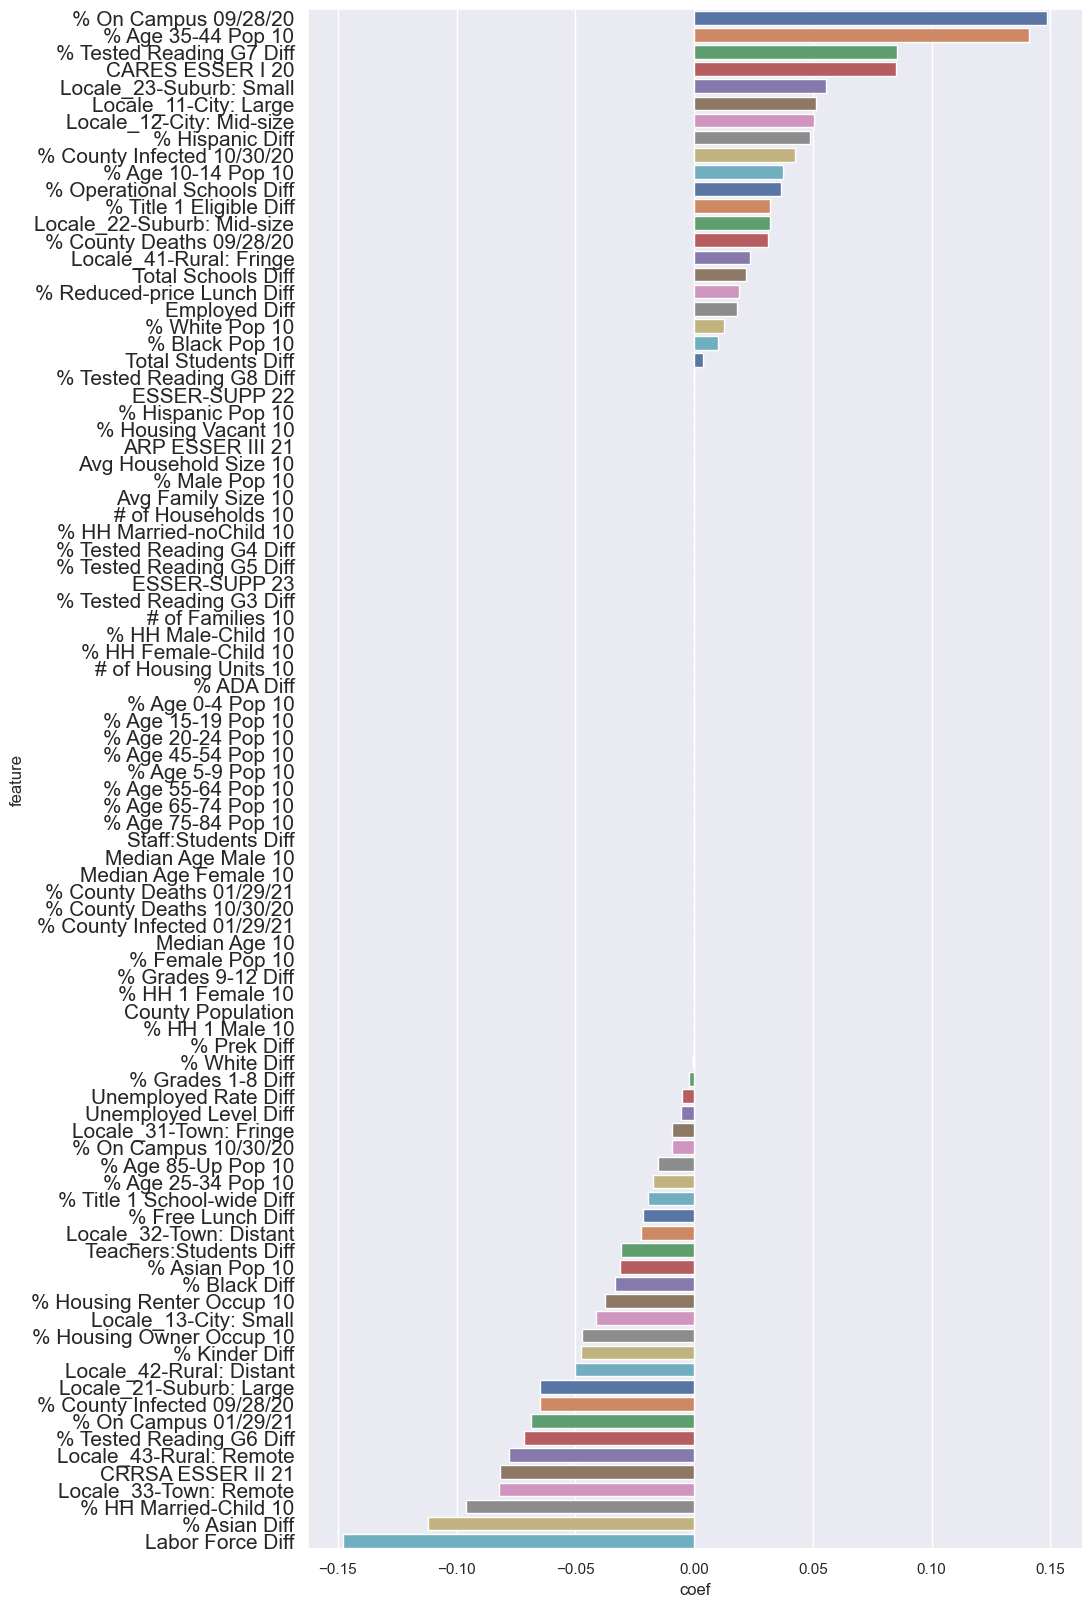

In [10]:
df_lasso2 = df_lasso2.sort_values(by=['coef'], ascending=False)
sns.set(rc={'figure.figsize':(10, 20)})
g=sns.barplot(data=df_lasso2, y="feature", x="coef", palette="deep", orient="h")
# g.set_xticklabels(g.get_xticklabels(), rotation=90, size=20)
g.set_yticklabels(g.get_yticklabels(), size=15)
plt.show()

### Random Forest Feature Importance ###

Train Score: 1.00
Test Score: 0.53


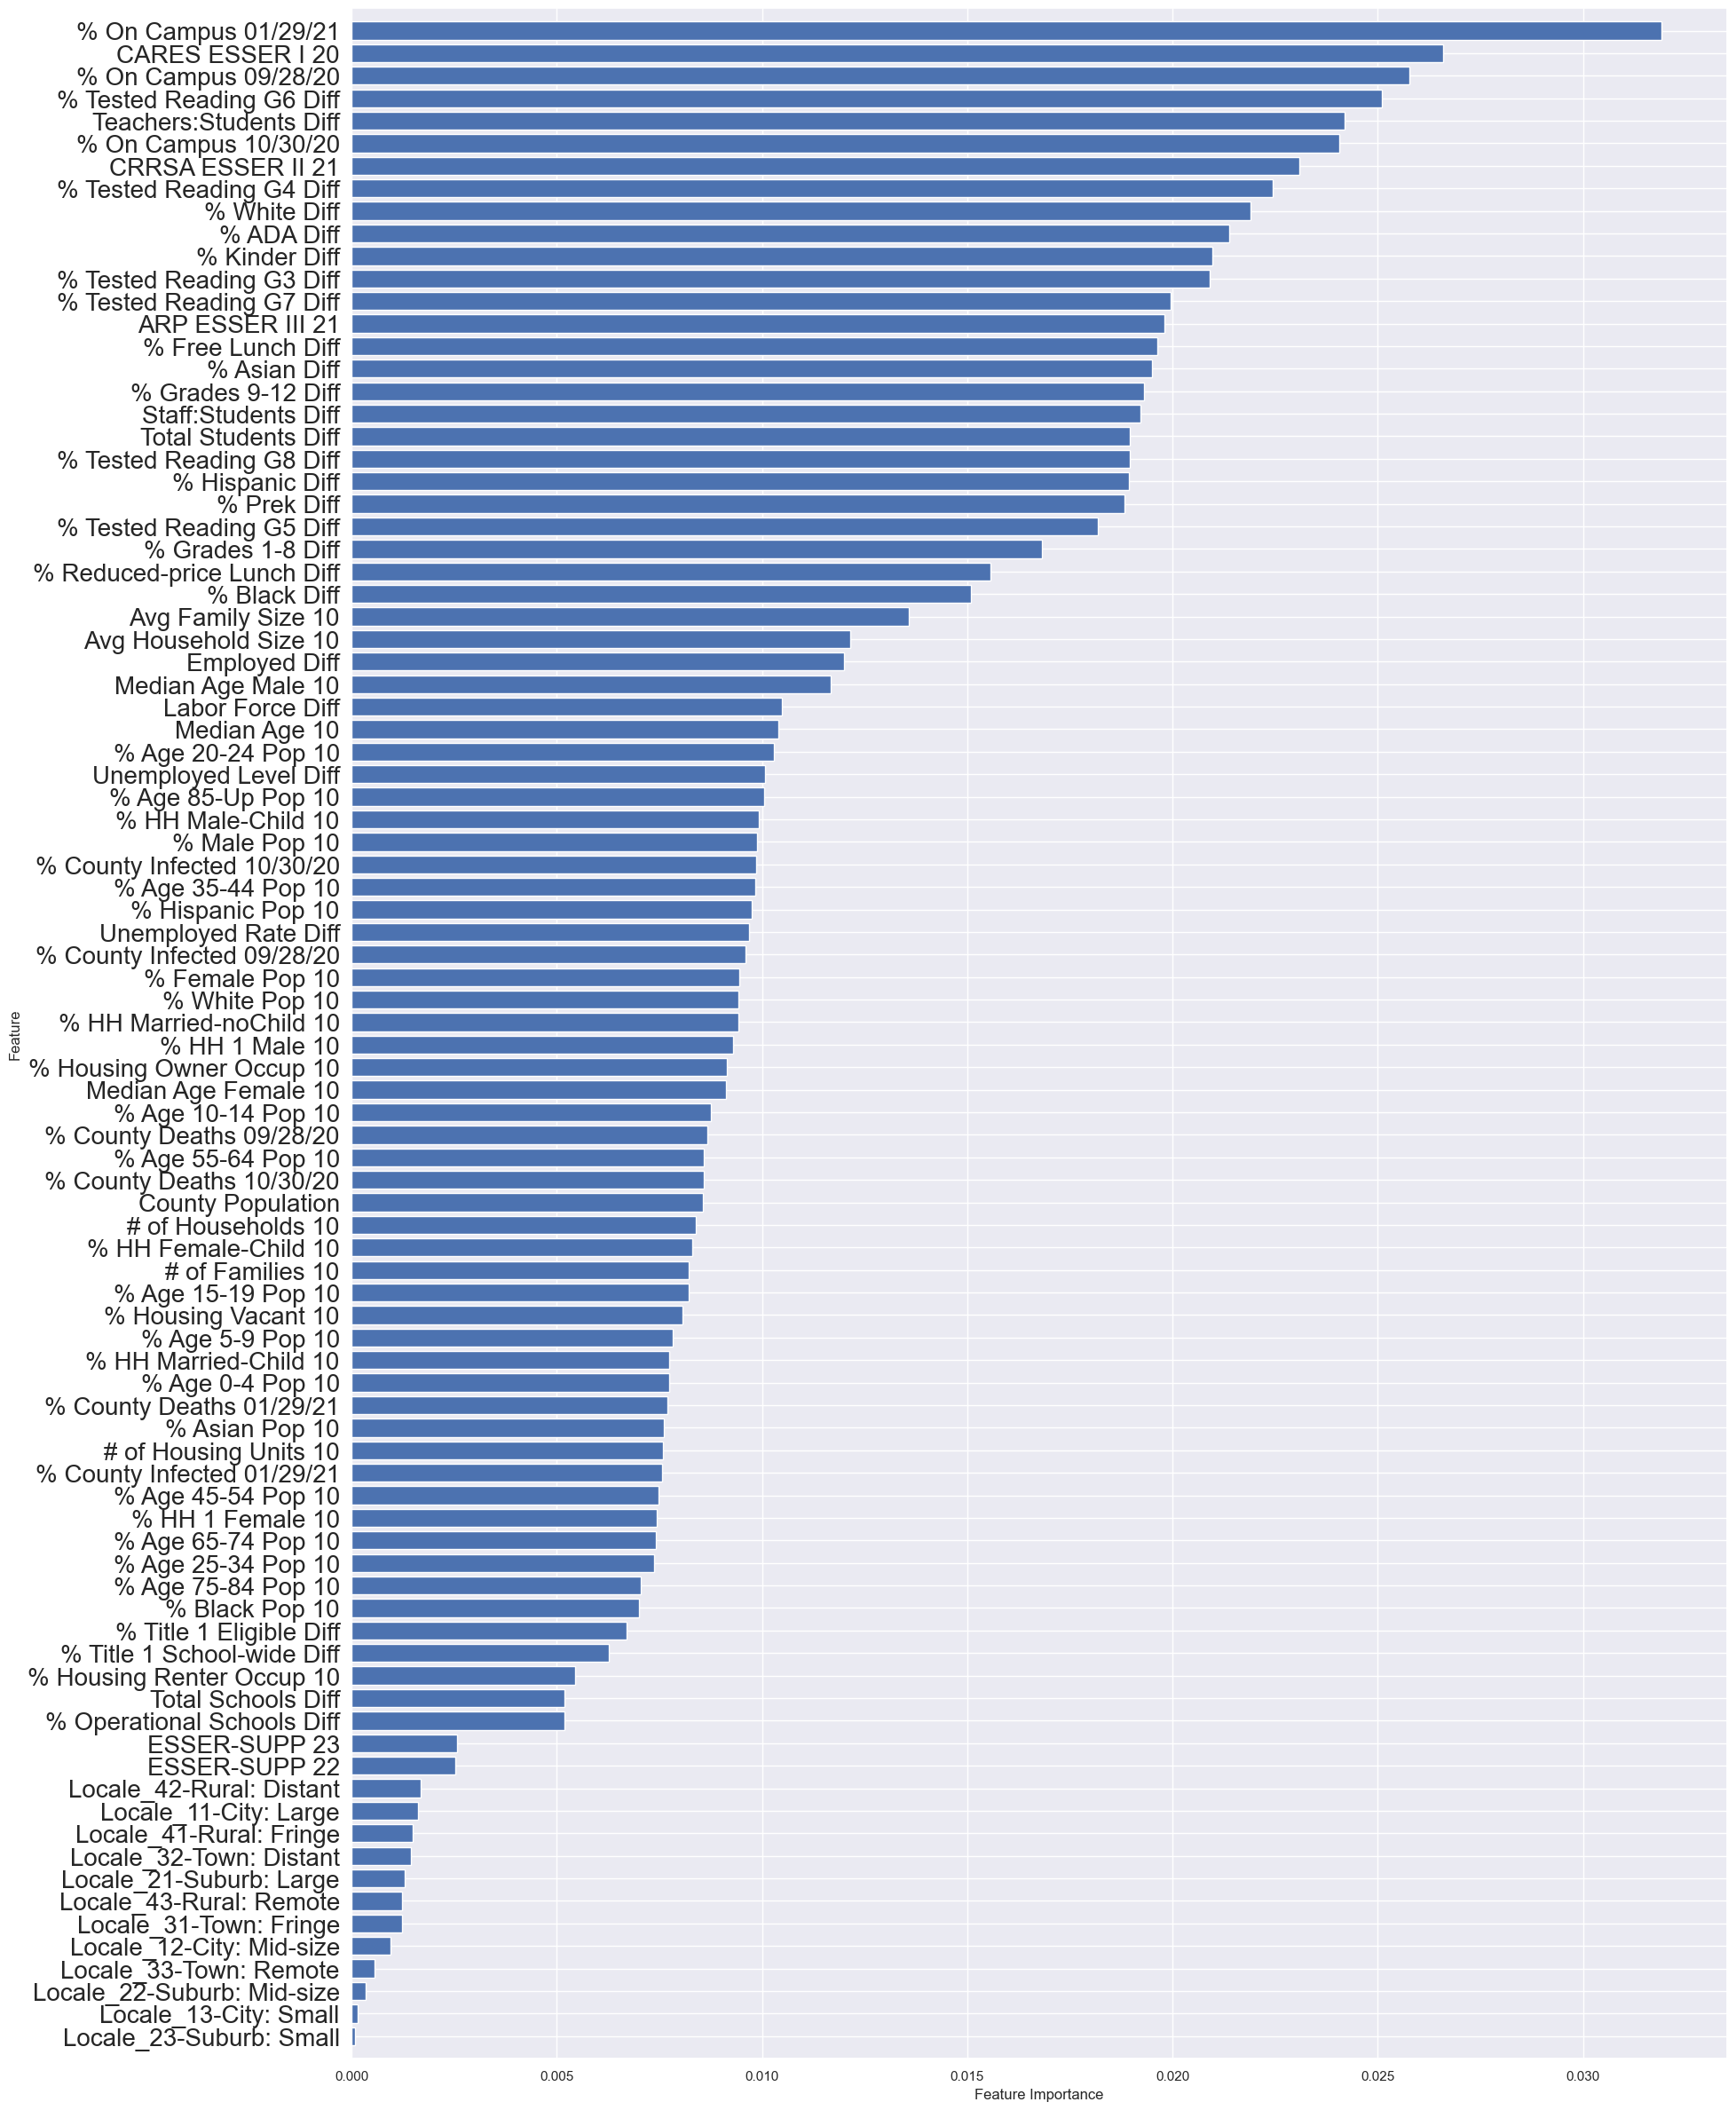

In [11]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,30))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.show()

temp = pd.DataFrame({'feature': columns, 
                        'method': 'Feature Importance',
                        'model': 'Random Forest', 
                        'score': importances,
                        'score_type': 'importances'})
results = pd.concat([results, temp], ignore_index=True)

### Permutation Importance ###
with Random Forest

Train Score: 1.00
Test Score: 0.53


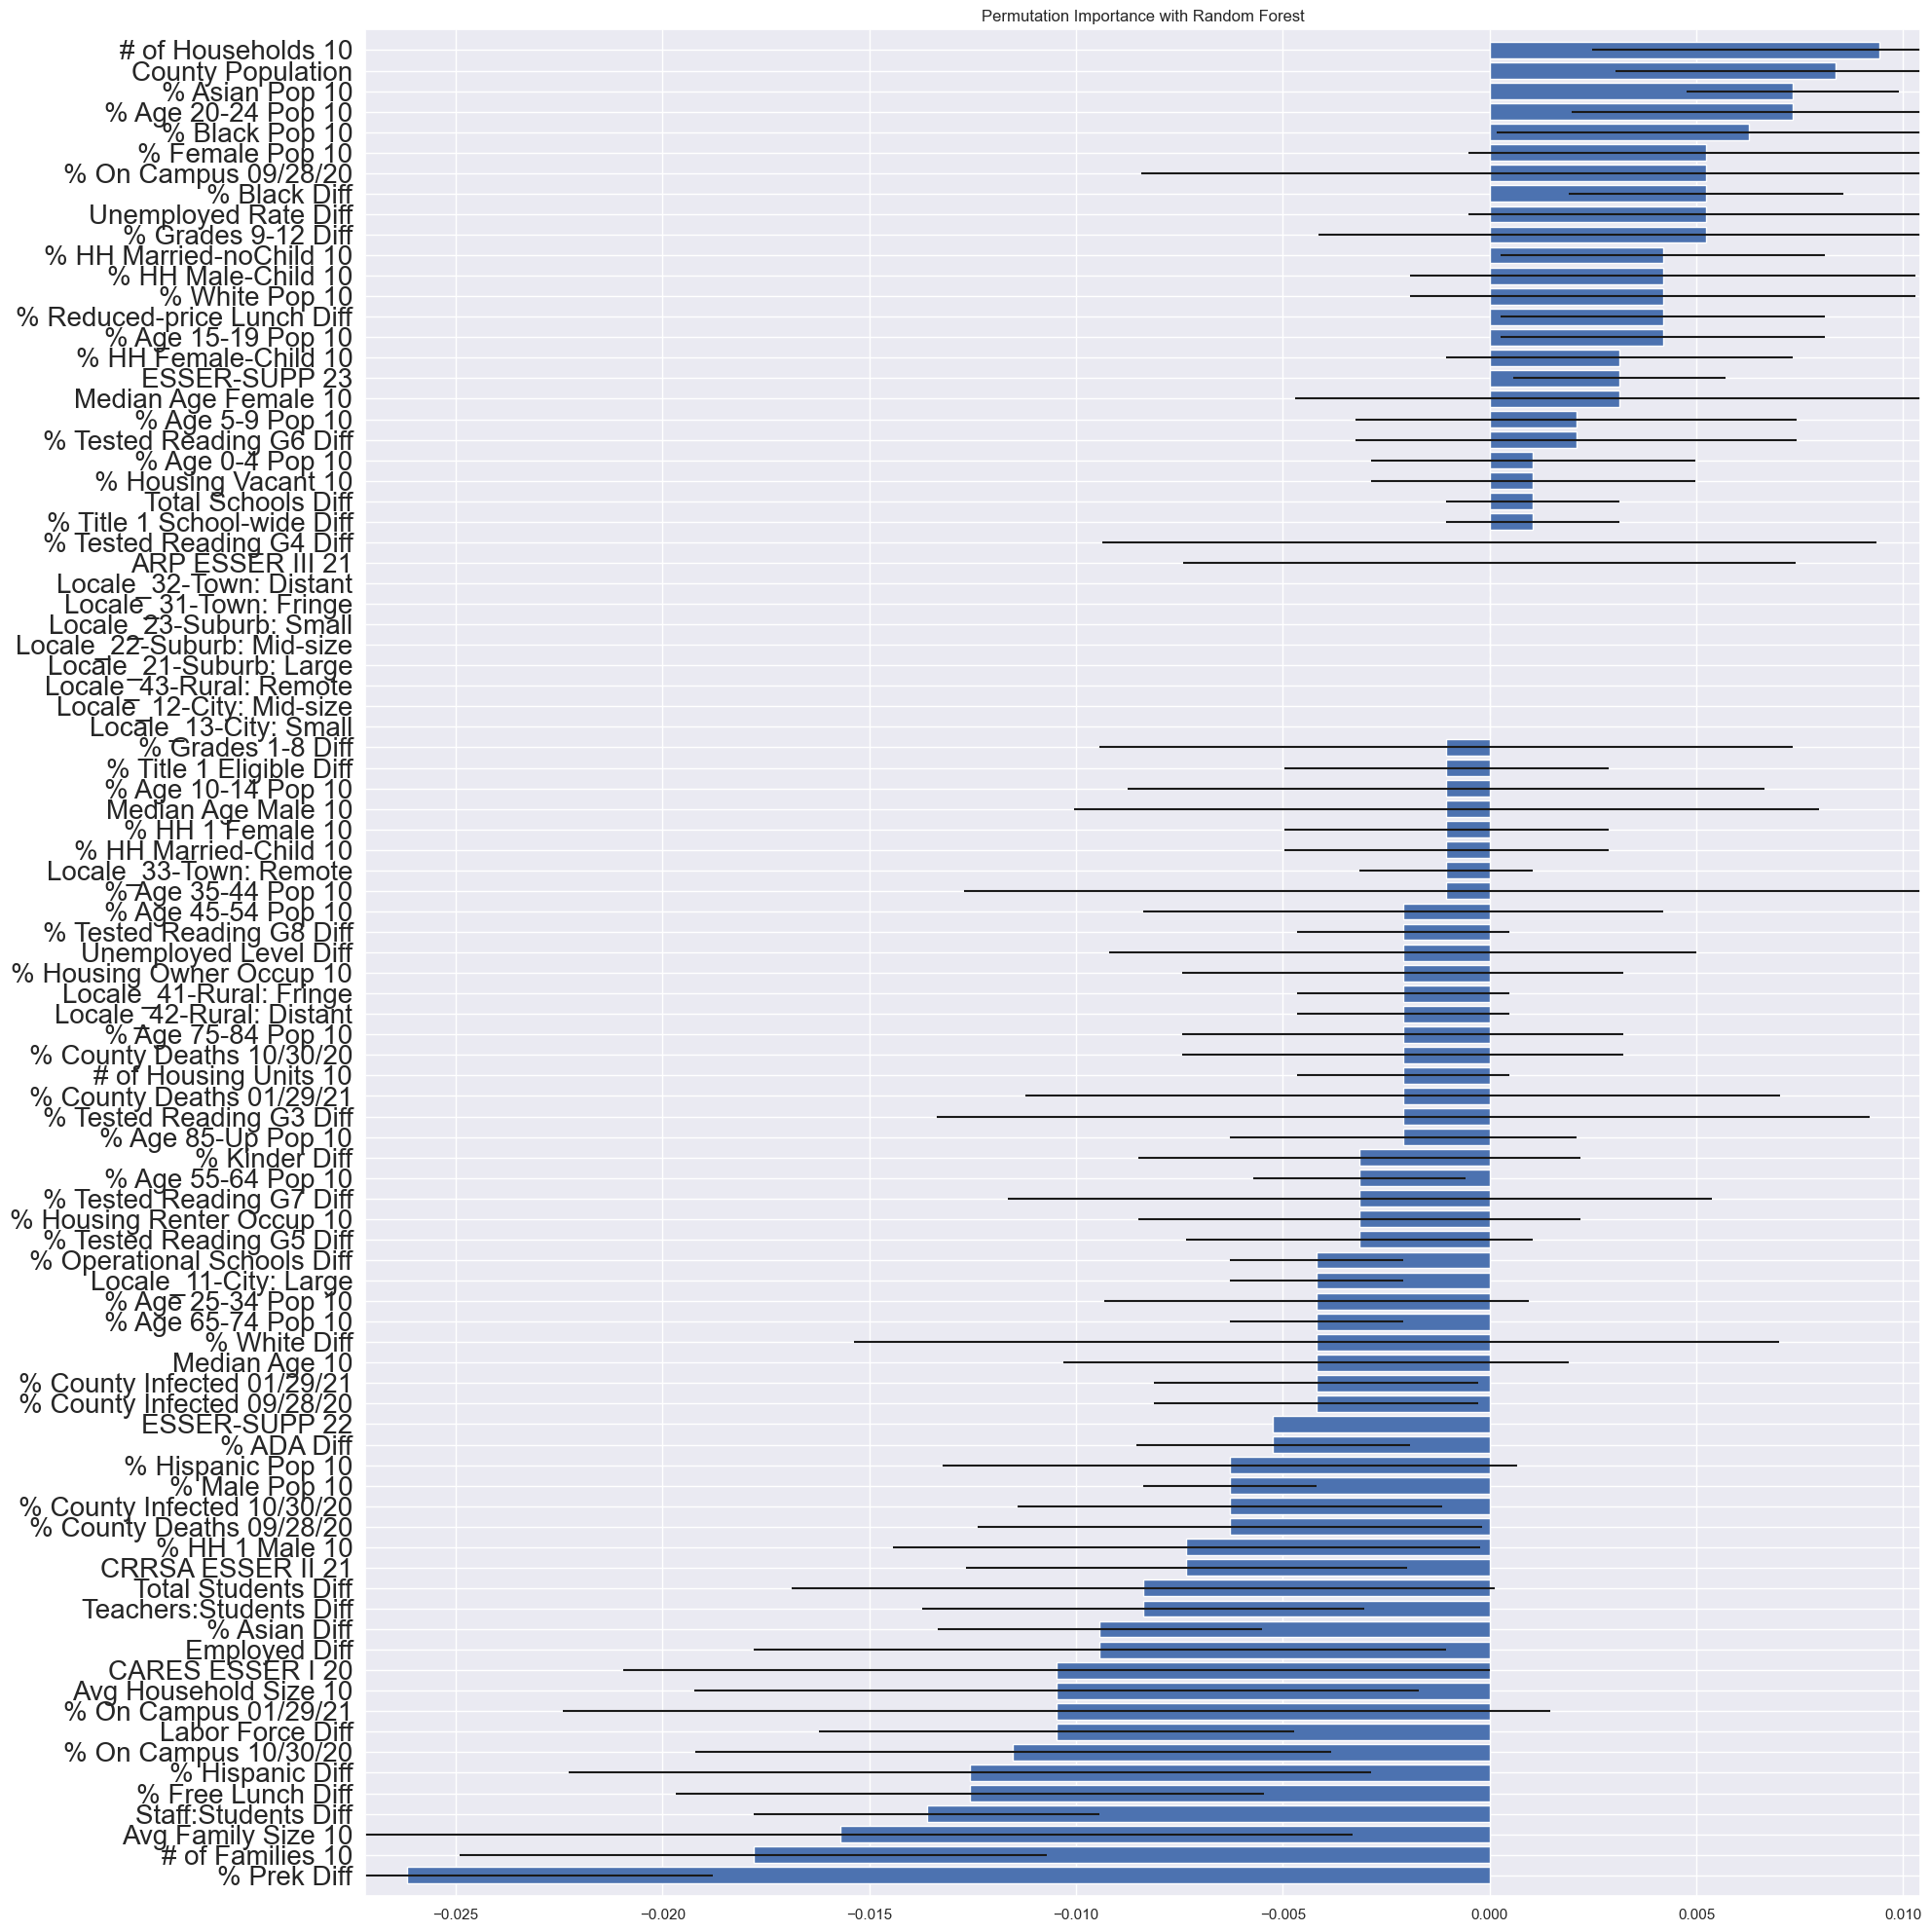

CPU times: user 2.32 s, sys: 415 ms, total: 2.74 s
Wall time: 7.49 s


In [12]:
%%time
from sklearn.inspection import permutation_importance

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

result = permutation_importance(estimator, X=X_test, y=y_test, scoring='accuracy', n_jobs=-1, random_state=random_state)
indices = np.argsort(result['importances_mean'])#[::-1]

plt.figure(figsize=(20,20))
plt.title("Permutation Importance with Random Forest")
plt.barh(range(X_train.shape[1]), result['importances_mean'][indices], xerr=result['importances_std'][indices])

plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.xlim([result['importances_mean'].min()-0.001, result['importances_mean'].max()+0.001])

plt.tight_layout()
plt.show()

temp = pd.DataFrame({'feature': columns, 
                     'method': 'Permutation Importance',
                     'model': 'Random Forest', 
                     'score': result['importances_mean'],
                     'score_type': 'importances_mean'})
results = pd.concat([results, temp], ignore_index=True)

### Permutation Importance ###
with Ridge Regression

Train Score: 0.64
Test Score: 0.54


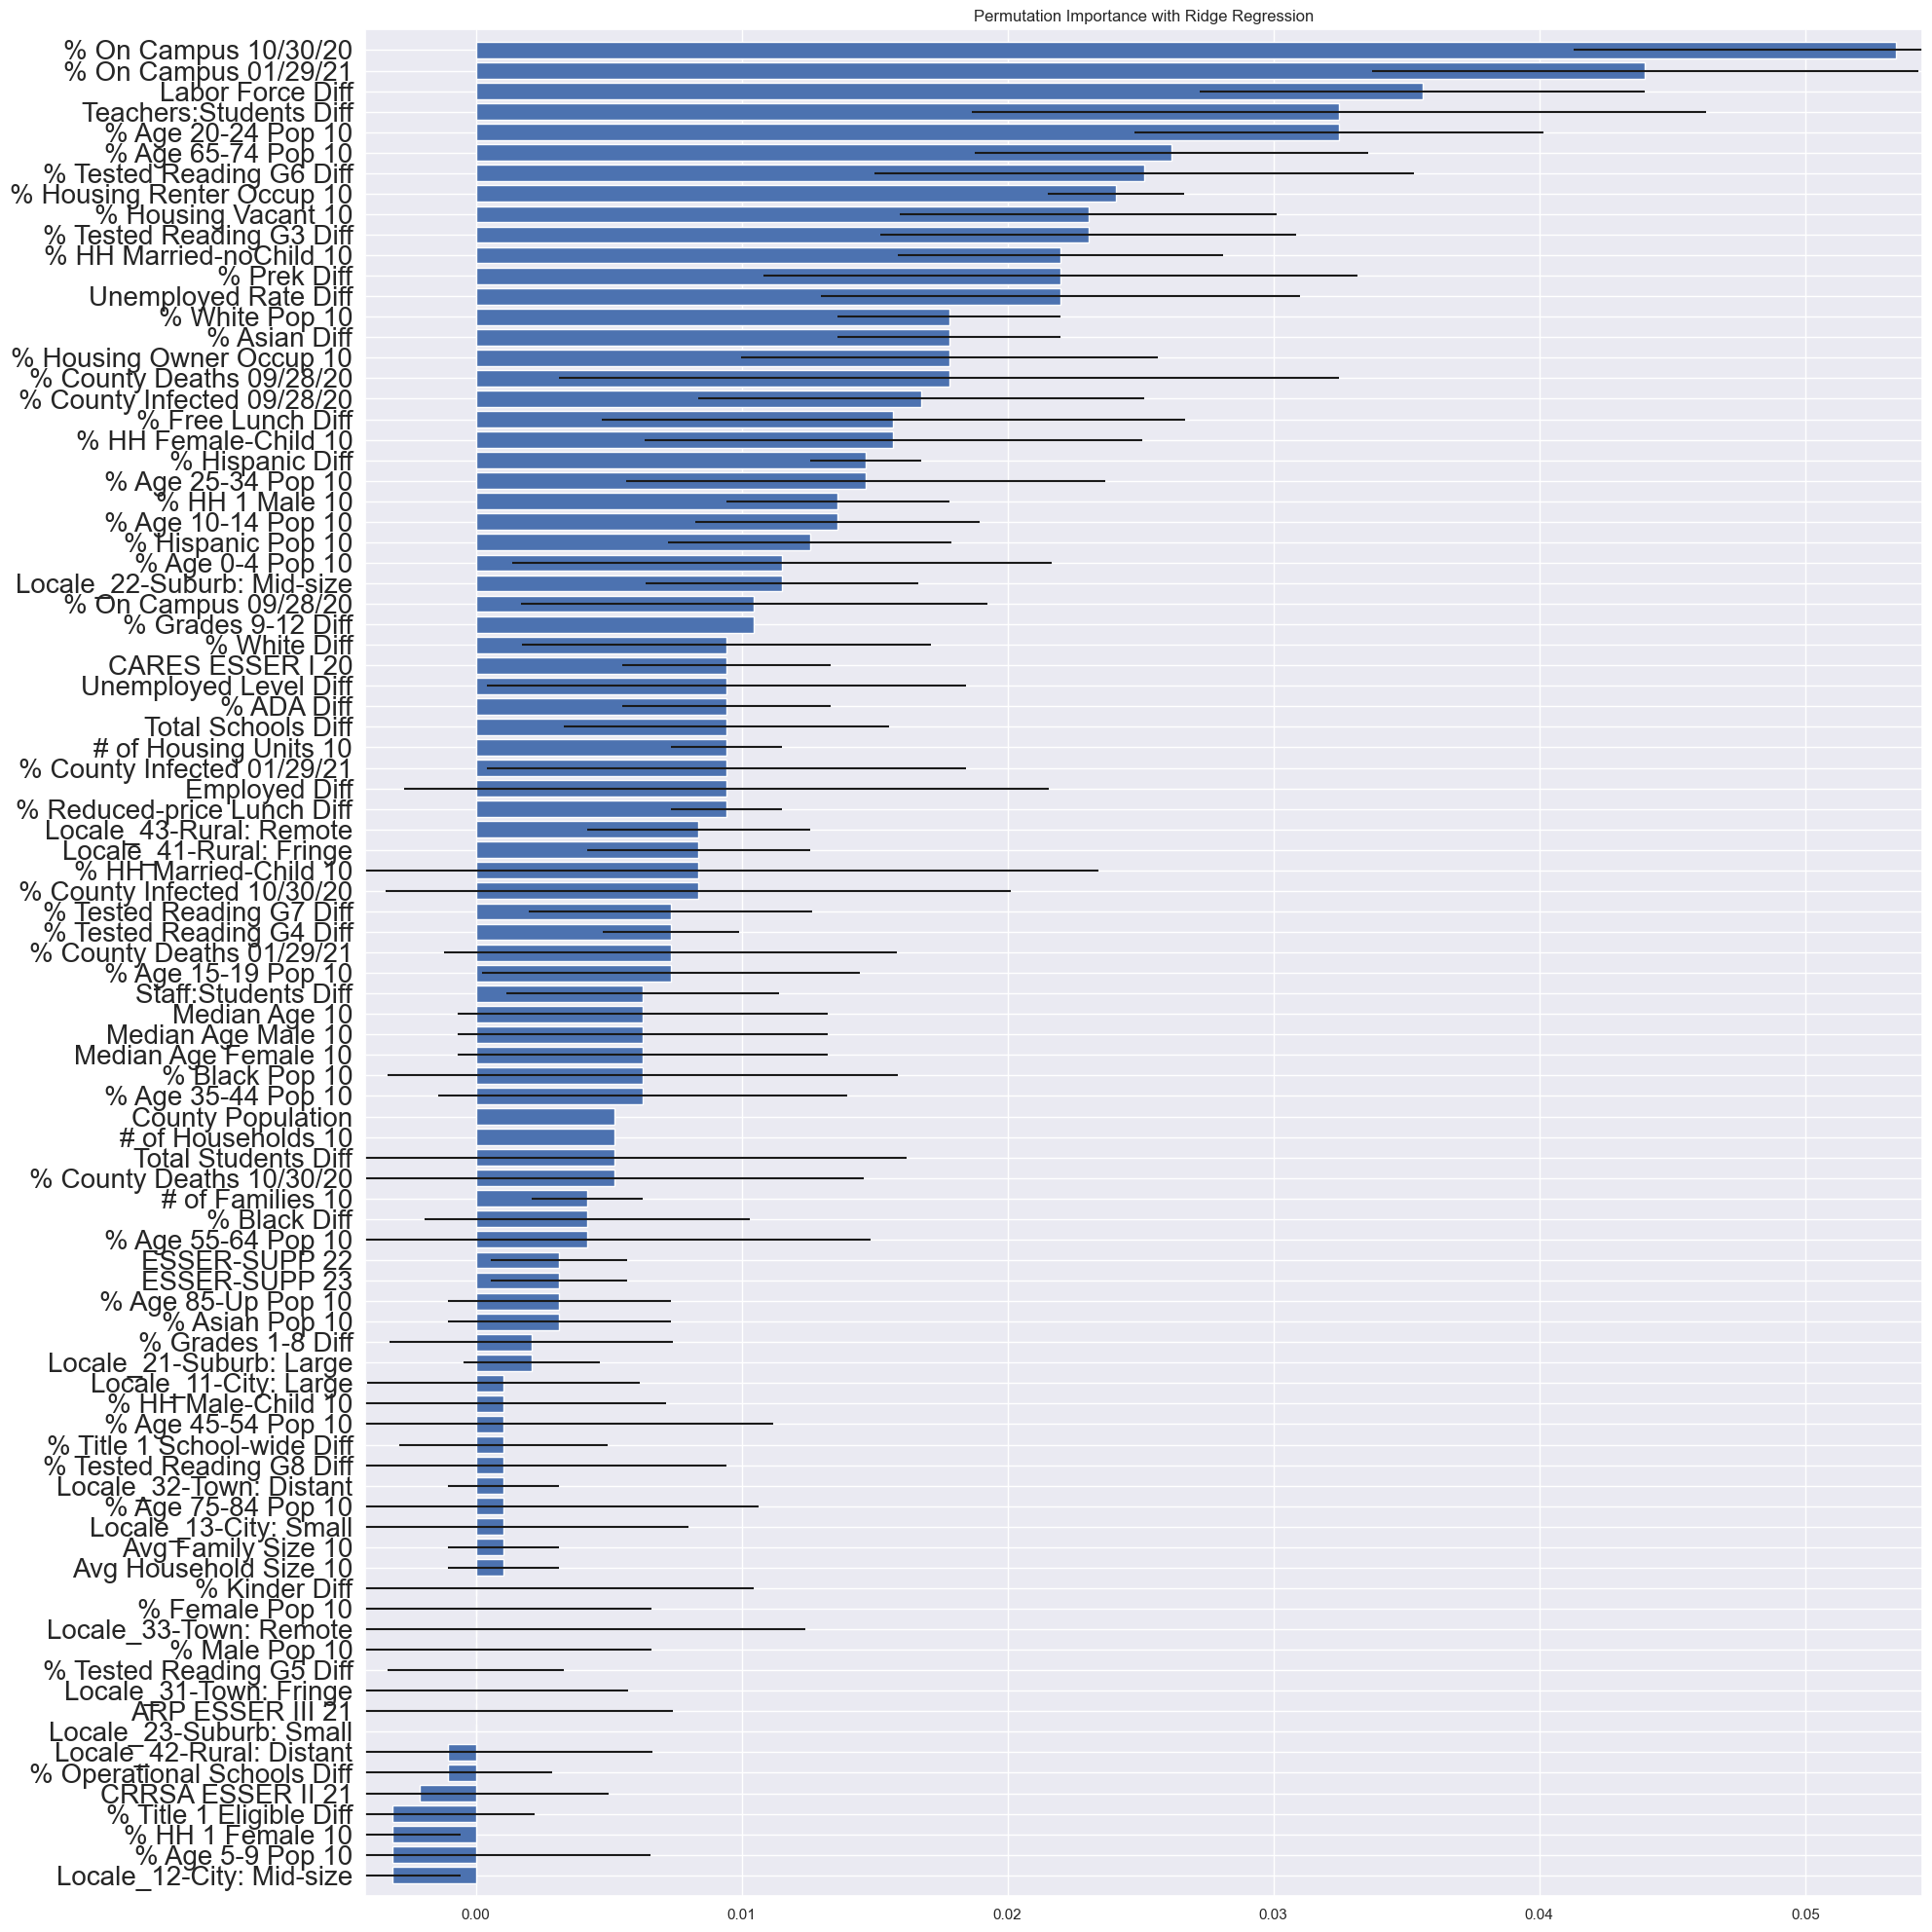

CPU times: user 750 ms, sys: 60.4 ms, total: 810 ms
Wall time: 1.05 s


In [13]:
%%time
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

result = permutation_importance(estimator, X=X_test, y=y_test, scoring='accuracy', n_jobs=-1, random_state=random_state)
indices = np.argsort(result['importances_mean'])#[::-1]

plt.figure(figsize=(20,20))
plt.title("Permutation Importance with Ridge Regression")
plt.barh(range(X_train.shape[1]), result['importances_mean'][indices], xerr=result['importances_std'][indices])

plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.xlim([result['importances_mean'].min()-0.001, result['importances_mean'].max()+0.001])

plt.tight_layout()
plt.show()

temp = pd.DataFrame({'feature': columns, 
                     'method': 'Permutation Importance',
                     'model': 'Ridge', 
                     'score': result['importances_mean'],
                     'score_type': 'importances_mean'})
results = pd.concat([results, temp], ignore_index=True)

### Recursive Feature Elimination(RFE) ###
with Ridge Regression

In [14]:
%time
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr', random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

rfe = RFECV(estimator, step=1, cv=10, n_jobs=-1)
sel = rfe.fit(X_train, y_train)
support = sel.support_
n_sel = sel.n_features_

print('n Selected: ', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'RFE',
                     'model': 'Ridge', 
                     'score': rfe.ranking_,
                     'score_type': 'ranking'})
results = pd.concat([results, temp], ignore_index=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
Train Score: 0.65
Test Score: 0.53
n Selected:  5
Selected Feature:  Index(['CARES ESSER I 20', 'CRRSA ESSER II 21', 'ARP ESSER III 21',
       'ESSER-SUPP 23', '% On Campus 10/30/20'],
      dtype='object')


### Recursive Feature Elimination(RFE) ###
with Random Forest

In [15]:
%time
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

rfe = RFECV(estimator, step=1, cv=5, n_jobs=-1)
sel = rfe.fit(X_train, y_train)
support = sel.support_
n_sel = sel.n_features_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'RFE',
                     'model': 'Random Forest', 
                     'score': rfe.ranking_,
                     'score_type': 'ranking'})
results = pd.concat([results, temp], ignore_index=True)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.81 µs
Train Score: 1.00
Test Score: 0.53
n Selected: 36
Selected Feature:  Index(['Labor Force Diff', 'Employed Diff', 'Unemployed Level Diff',
       'Median Age Female 10', 'Avg Household Size 10', '# of Families 10',
       'CARES ESSER I 20', 'CRRSA ESSER II 21', 'ARP ESSER III 21',
       '% County Infected 09/28/20', '% On Campus 09/28/20',
       '% On Campus 10/30/20', '% On Campus 01/29/21', '% Male Pop 10',
       '% Age 35-44 Pop 10', '% HH Married-noChild 10', 'Total Students Diff',
       'Teachers:Students Diff', 'Staff:Students Diff', '% Free Lunch Diff',
       '% Reduced-price Lunch Diff', '% Asian Diff', '% Hispanic Diff',
       '% Black Diff', '% White Diff', '% Grades 1-8 Diff',
       '% Grades 9-12 Diff', '% Prek Diff', '% Kinder Diff', '% ADA Diff',
       '% Tested Reading G3 Diff', '% Tested Reading G4 Diff',
       '% Tested Reading G5 Diff', '% Tested Reading G6 Diff',
       '% Tested Reading

### Sequential Feature Selection(SFS) ###
with KNN

In [16]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier(n_neighbors=3)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

sfs = SequentialFeatureSelector(estimator, n_jobs=-1, n_features_to_select='auto', tol=None)
sfs.fit(X_train, y_train)

support = sfs.get_support()
n_sel = sfs.n_features_to_select_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'SFS',
                     'model': 'KNN', 
                     'score': [1 if ft in columns[support] else 0 for ft in columns],
                     'score_type': 'N/A'})
results = pd.concat([results, temp], ignore_index=True)

Train Score: 0.74
Test Score: 0.54
n Selected: 45
Selected Feature:  Index(['Employed Diff', 'Unemployed Level Diff', 'Median Age 10',
       'Median Age Male 10', 'Median Age Female 10', '# of Households 10',
       'Avg Household Size 10', '# of Families 10', 'Avg Family Size 10',
       '# of Housing Units 10', 'County Population', 'CARES ESSER I 20',
       'CRRSA ESSER II 21', 'ARP ESSER III 21', 'ESSER-SUPP 22',
       'ESSER-SUPP 23', '% On Campus 09/28/20', '% On Campus 10/30/20',
       '% On Campus 01/29/21', '% Black Pop 10', '% Asian Pop 10',
       '% Age 20-24 Pop 10', '% Age 85-Up Pop 10', 'Total Schools Diff',
       'Total Students Diff', '% Operational Schools Diff',
       '% Title 1 Eligible Diff', 'Staff:Students Diff',
       '% Reduced-price Lunch Diff', '% White Diff', '% Prek Diff',
       '% Tested Reading G4 Diff', '% Tested Reading G7 Diff',
       'Locale_11-City: Large', 'Locale_12-City: Mid-size',
       'Locale_13-City: Small', 'Locale_21-Suburb: Large',

### Sequential Feature Selection(SFS) ###
with Ridge Regression

In [17]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', multi_class='ovr', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

sfs = SequentialFeatureSelector(estimator, n_jobs=-1, n_features_to_select='auto', tol=None)
sfs.fit(X_train, y_train)

support = sfs.get_support()
n_sel = sfs.n_features_to_select_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'SFS',
                     'model': 'Ridge', 
                     'score': [1 if ft in columns[support] else 0 for ft in columns],
                     'score_type': 'N/A'})
results = pd.concat([results, temp], ignore_index=True)

Train Score: 0.64
Test Score: 0.54
n Selected: 45
Selected Feature:  Index(['Labor Force Diff', 'CARES ESSER I 20', 'CRRSA ESSER II 21',
       'ARP ESSER III 21', 'ESSER-SUPP 22', 'ESSER-SUPP 23',
       '% County Infected 01/29/21', '% On Campus 09/28/20',
       '% On Campus 01/29/21', '% Male Pop 10', '% Female Pop 10',
       '% Age 5-9 Pop 10', '% Age 15-19 Pop 10', '% Age 20-24 Pop 10',
       '% Age 55-64 Pop 10', '% Age 65-74 Pop 10', '% HH 1 Male 10',
       '% HH Male-Child 10', '% Housing Vacant 10', '% Housing Owner Occup 10',
       '% Housing Renter Occup 10', 'Total Schools Diff',
       '% Operational Schools Diff', '% Title 1 School-wide Diff',
       '% Title 1 Eligible Diff', '% Free Lunch Diff',
       '% Reduced-price Lunch Diff', '% Black Diff', '% Grades 1-8 Diff',
       '% Grades 9-12 Diff', '% Prek Diff', '% Kinder Diff', '% ADA Diff',
       '% Tested Reading G3 Diff', '% Tested Reading G4 Diff',
       '% Tested Reading G5 Diff', '% Tested Reading G6 Diff',

### Result: Number of Feature Selected ###

In [18]:
results['selected'] = results['score'].apply(lambda x: 1 if x > 0 else 0)

th_quantile=0.5
th_rf = results[results['method'] == 'Feature Importance']['score'].quantile(th_quantile)
print('Threshold for Random Forest Feature Importance is {:0.4f} at {:0.0f}th percentile'.format(th_rf, th_quantile*100))
results['selected'] = results.apply(lambda x: 0 if ((x.method == 'Feature Importance') & (x.score < th_rf))
                                                 else x.selected, axis=1)
results['selected'] = results.apply(lambda x: 0 if ((x.method == 'RFE') & (x.score > 1))
                                                 else x.selected, axis=1)
results['selected'] = results.apply(lambda x: 1 if ((x.method == 'Regularization') & (x.score != 0))
                                                 else x.selected, axis=1)
              
results['Method'] = results.apply(lambda x: 'Variance Threshold' if x.method == 'Variance Threshold'
                                                                 else str(x.method) + " - " + str(x.model), axis=1)

Threshold for Random Forest Feature Importance is 0.0094 at 50th percentile


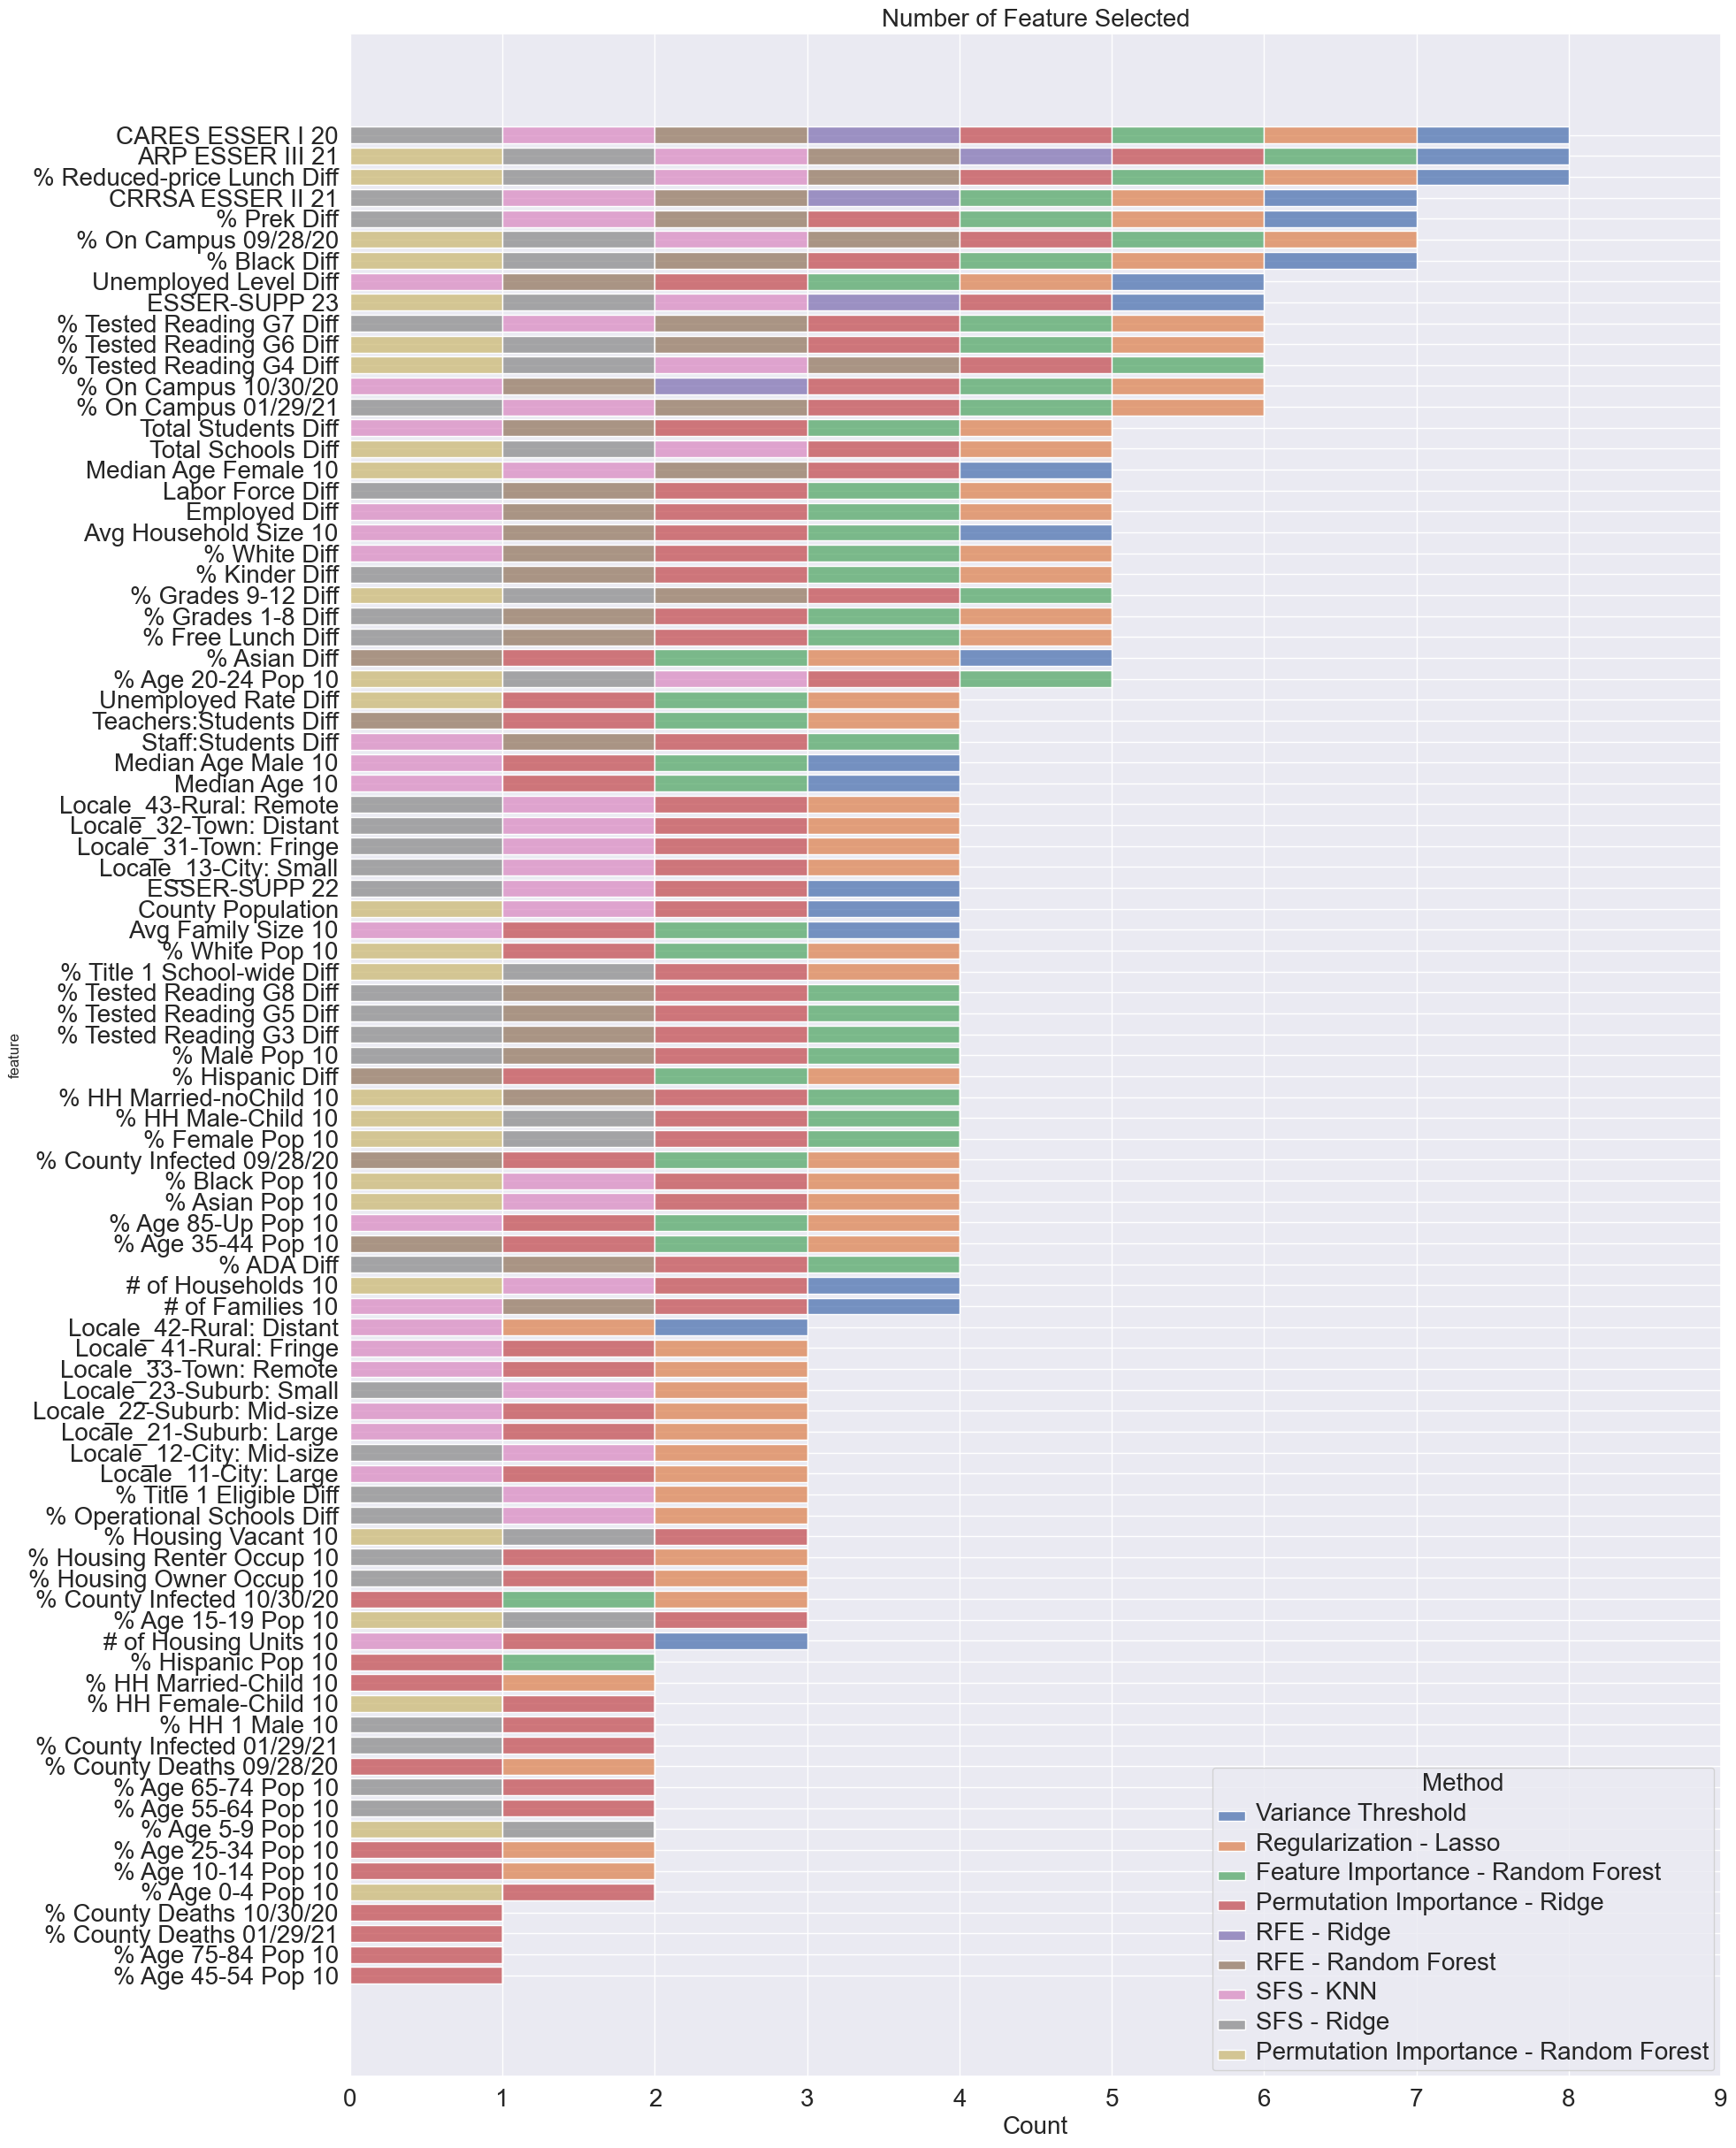

In [19]:
sns.set(rc={'figure.figsize':(20,30)})

features_selected = results[results['selected'] == 1].copy()
features_selected['counts']=features_selected.groupby('feature').transform(lambda x: x.sum())['selected']
features_selected = features_selected.sort_values(by=['counts', 'feature'], ascending=False)

g = sns.histplot(data=features_selected, y='feature', hue='Method', multiple='stack', shrink=0.8, legend=True)
plt.title('Number of Feature Selected', size=20)
plt.xlabel('Count', size=20)
plt.xticks(range(len(features_selected['Method'].unique())+1), list(range(len(features_selected['Method'].unique())+1)), size=20)
plt.yticks(range(len(features_selected.feature.unique())), features_selected.feature.unique(), size=20)
# plt.legend(fontsize=20)
plt.setp(g.get_legend().get_texts(), fontsize='20')
plt.setp(g.get_legend().get_title(), fontsize='20') 
plt.show()

In [20]:
features_selected2 = features_selected.groupby(['feature'], as_index=False).agg({'counts': 'count'})
features_selected2 = features_selected2.sort_values(by=['counts'], ascending=False)
features_selected2[:20]

feature  counts
47  % Reduced-price Lunch Diff       8
58            ARP ESSER III 21       8
61            CARES ESSER I 20       8
62           CRRSA ESSER II 21       7
18                % Black Diff       7
46                 % Prek Diff       7
43        % On Campus 09/28/20       7
44        % On Campus 10/30/20       6
42        % On Campus 01/29/21       6
87       Unemployed Level Diff       6
49    % Tested Reading G4 Diff       6
51    % Tested Reading G6 Diff       6
52    % Tested Reading G7 Diff       6
65               ESSER-SUPP 23       6
60       Avg Household Size 10       5
40               % Kinder Diff       5
86         Total Students Diff       5
56                % White Diff       5
29          % Grades 9-12 Diff       5
28           % Grades 1-8 Diff       5

In [21]:
results.to_csv('Feature_Selection_Reading_Results.csv', index=False)
results

feature              method  model  score score_type  \
0            Labor Force Diff  Variance Threshold    N/A    0.0        N/A   
1               Employed Diff  Variance Threshold    N/A    0.0        N/A   
2       Unemployed Level Diff  Variance Threshold    N/A    1.0        N/A   
3        Unemployed Rate Diff  Variance Threshold    N/A    0.0        N/A   
4               Median Age 10  Variance Threshold    N/A    1.0        N/A   
..                        ...                 ...    ...    ...        ...   
805   Locale_32-Town: Distant                 SFS  Ridge    1.0        N/A   
806    Locale_33-Town: Remote                 SFS  Ridge    0.0        N/A   
807   Locale_41-Rural: Fringe                 SFS  Ridge    0.0        N/A   
808  Locale_42-Rural: Distant                 SFS  Ridge    0.0        N/A   
809   Locale_43-Rural: Remote                 SFS  Ridge    1.0        N/A   

     selected              Method  
0           0  Variance Threshold  
1           0  Variance Threshold  
2           1  Variance Threshold  
3           0  Variance Threshold  
4           1  Variance Threshold  
..        ...                 ...  
805         1         SFS - Ridge  
806         0         SFS - Ridge  
807         0         SFS - Ridge  
808         0         SFS - Ridge  
809         1         SFS - Ridge  

[810 rows x 7 columns]

In [22]:
importance=results.pivot(index="feature", columns="Method", values="score").reset_index()
importance.to_csv('importance_reading.csv', index=False)
importance

Method                 feature  Feature Importance - Random Forest  \
0             # of Families 10                            0.008221   
1           # of Households 10                            0.008380   
2        # of Housing Units 10                            0.007590   
3                   % ADA Diff                            0.021379   
4             % Age 0-4 Pop 10                            0.007731   
..                         ...                                 ...   
85      Teachers:Students Diff                            0.024186   
86          Total Schools Diff                            0.005196   
87         Total Students Diff                            0.018969   
88       Unemployed Level Diff                            0.010081   
89        Unemployed Rate Diff                            0.009685   

Method  Permutation Importance - Random Forest  \
0                                    -0.017801   
1                                     0.009424   
2                                    -0.002094   
3                                    -0.005236   
4                                     0.001047   
..                                         ...   
85                                   -0.008377   
86                                    0.001047   
87                                   -0.008377   
88                                   -0.002094   
89                                    0.005236   

Method  Permutation Importance - Ridge  RFE - Random Forest  RFE - Ridge  \
0                             0.004188                  1.0         84.0   
1                             0.005236                 37.0         82.0   
2                             0.009424                 26.0         83.0   
3                             0.009424                  1.0         81.0   
4                             0.011518                 40.0         18.0   
..                                 ...                  ...          ...   
85                            0.032461                  1.0         46.0   
86                            0.009424                 38.0         56.0   
87                            0.005236                  1.0         47.0   
88                            0.009424                  1.0         77.0   
89                            0.021990                  6.0         38.0   

Method  Regularization - Lasso  SFS - KNN  SFS - Ridge  Variance Threshold  
0                     0.000000        1.0          0.0                 1.0  
1                     0.000000        1.0          0.0                 1.0  
2                     0.000000        1.0          0.0                 1.0  
3                     0.000000        0.0          1.0                 0.0  
4                     0.000000        0.0          0.0                 0.0  
..                         ...        ...          ...                 ...  
85                   -0.030688        0.0          0.0                 0.0  
86                    0.021757        1.0          1.0                 0.0  
87                    0.003947        1.0          0.0                 0.0  
88                   -0.005435        1.0          0.0                 1.0  
89                   -0.004892        0.0          0.0                 0.0  

[90 rows x 10 columns]